In [1]:
import math
import random
import numpy as np
from plot_utils import draw_dot
from tqdm import tqdm

LR = 0.01

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        # (self, ) is passed so that it behaves like a tuple
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

def get_value_array(shape):
    """
    A numpy array of shape `shape` randomly initialized between -1 and 1
    """
    if len(shape) == 1:
        return np.array([Value(random.uniform(-1.0, 1.0)) for _ in range(shape[0])])
    
    return np.array([get_value_array(shape[1:]) for _ in range(shape[0])])

def np_array_to_value_array(arr):
    """
    Convert a numpy array to a Value array
    """
    if len(arr.shape) == 1:
        return np.array([Value(v) for v in arr])
    
    return np.array([np_array_to_value_array(v) for v in arr])

def zero_grad_value_array(arr):
    """
    Set the gradient of all elements to 0
    """
    for v in arr.flatten():
        v.grad = 0.0
    
    return

def gradient_descent_value_array(arr, lr = LR):
    """
    Replace every `item` with `item - lr * item.grad`
    """
    for v in arr.flatten():
        v.data -= lr * v.grad

    return

class DenseLayer:
    def __init__(self, units, dim):
        self.W = get_value_array((units, dim))
        self.b = get_value_array((units, ))

        self.units = units
        self.dim = dim

    def forward(self, x):
        """
        Dimension of x should be (self.dim, ).
        Sigmoid activation is applied to the output.
        """
        assert x.shape == (self.dim, ), f"Shape should be ({self.dim}, ), got {x.shape}"

        Z = self.W @ x + self.b

        # Z.shape will be (self.units, )

        A = np.array([1.0/(1.0 + (-v).exp()) for v in Z])

        return A
    
    def zero_grad(self):
        zero_grad_value_array(self.W)
        zero_grad_value_array(self.b)

    def update(self, lr = LR):
        gradient_descent_value_array(self.W, lr = lr)
        gradient_descent_value_array(self.b, lr = lr)

class Conv2D:
    def __init__(self, input_shape = (64, 64),
                 num_filters = 4,
                 kernel_size = 4,
                 strides = 2,
                 padding = 0):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

        # Only for square images
        self.op_shape = (input_shape[0] + 2*padding - kernel_size) // strides + 1

        self.flattened_op_len = self.num_filters * (self.op_shape ** 2)

        # Kernel weights
        self.K = get_value_array((num_filters, kernel_size, kernel_size))

    def forward(self, x):
        """
        Dimension of x should be: `self.input_shape`.
        ReLU activation is applied to the output.
        """
        # Pad the input
        x = np.pad(x, ((self.padding, self.padding), (self.padding, self.padding)),
                   constant_values=Value(0.0))
        
        # Assigment operator is overloaded for Value
        res = get_value_array((self.num_filters, self.op_shape, self.op_shape))

        for f in range(self.num_filters):
            for i in range(self.op_shape):
                for j in range(self.op_shape):
                    i_start = i*self.strides
                    i_end = i_start + self.kernel_size
                    j_start = j*self.strides
                    j_end = j_start + self.kernel_size

                    temp_val = np.sum(x[i_start: i_end, j_start: j_end] * self.K[f])

                    # Apply ReLU
                    res[f][i][j] = temp_val.relu()
        
        return res
    
    def zero_grad(self):
        zero_grad_value_array(self.K)

    def update(self, lr = LR):
        gradient_descent_value_array(self.K, lr = lr)

In [2]:
def loss_fn(y_true, y_pred):
    """
    Mean Squared Error loss function
    """
    ls = (y_true - y_pred)**2
    # Return the value from the array
    # Squeeze the array
    return ls.squeeze()

In [3]:
class Model:
    def __init__(self, input_shape = (64, 64), kernel_size = 4, strides = 2, padding = 0, 
                 num_filters = 4, dense_units = 1):
        self.conv_1 = Conv2D(input_shape = input_shape, num_filters = num_filters,
                             kernel_size = kernel_size, strides = strides, padding = padding)
        
        self.dense_1 = DenseLayer(units = dense_units, dim = self.conv_1.flattened_op_len)

    def fit(self, X, y, num_epochs = 5,
            steps_per_epoch = 10,
            batch_size = 4,
            lr = LR):
        for ep in range(num_epochs):
            for _ in tqdm(range(steps_per_epoch), desc=f'Epoch {str(ep+1)}'):
                # Pick a random batch of images
                idx = np.random.choice(X.shape[0], batch_size)
                X_batch = X[idx]
                y_batch = y[idx]

                losses = []

                for i in range(batch_size):
                    A = self.forward(X_batch[i])
                    # Calculate the loss
                    ls = loss_fn(y_batch[i], A)
                    losses.append(ls)

                comb_loss = sum(losses) / batch_size

                # Set all the gradients to 0
                self.zero_grad()

                # Backpropagate the loss
                comb_loss.backward()

                # Update the weights
                self.update(lr = lr)

    
    def forward(self, x):
        """
        x should be of shape `self.input_shape`
        """
        conv_op = self.conv_1.forward(x)
        # Flatten the output
        flattened_op = conv_op.flatten()
        dense_op = self.dense_1.forward(flattened_op)
        return dense_op
    
    def zero_grad(self):
        self.conv_1.zero_grad()
        self.dense_1.zero_grad()

    def update(self, lr = LR):
        self.conv_1.update(lr = lr)
        self.dense_1.update(lr = lr)

#### Note
If `np.ndarray` has `dtype = object`, then the `flatten` method will return a 1D array of the objects which are reference to the original objects. So, if you change the value of an element in the flattened array, the value of the original array will also change. This is because the flattened array is a reference to the original array. It is not a copy of that.<br>
However if `dtype = int`, then it won't effect the original array because integers are not passed by reference.

##### Testing code in the below cells

In [32]:
W = get_value_array((2, 3))
b = get_value_array((2, ))
x = get_value_array((3, ))
y = W @ x + b
y[0].grad = 1.0
print(y[0].grad)
zero_grad_value_array(y)
print(y[0].grad)
print(y)
print(y.shape)
print(y[0])

1.0
0.0
[Value(data=-0.37799645765910683, grad=0.0)
 Value(data=-0.9739860047196822, grad=0.0)]
(2,)
Value(data=-0.37799645765910683, grad=0.0)


In [27]:
x = get_value_array((3, ))
dl = DenseLayer(1, 3)
y = dl.forward(x)
y[0].backward()
print(dl.W[0][0])
print(dl.b[0])

dl.update()
print(dl.W[0][0])
print(dl.b[0])

dl.zero_grad()
print(dl.W[0][0])
print(dl.b[0])

Value(data=0.11208673505581457, grad=0.16953834912509008)
Value(data=0.8062735881744223, grad=0.1700489993962777)
Value(data=0.11039135156456367, grad=0.16953834912509008)
Value(data=0.8045730981804595, grad=0.1700489993962777)
Value(data=0.11039135156456367, grad=0.0)
Value(data=0.8045730981804595, grad=0.0)


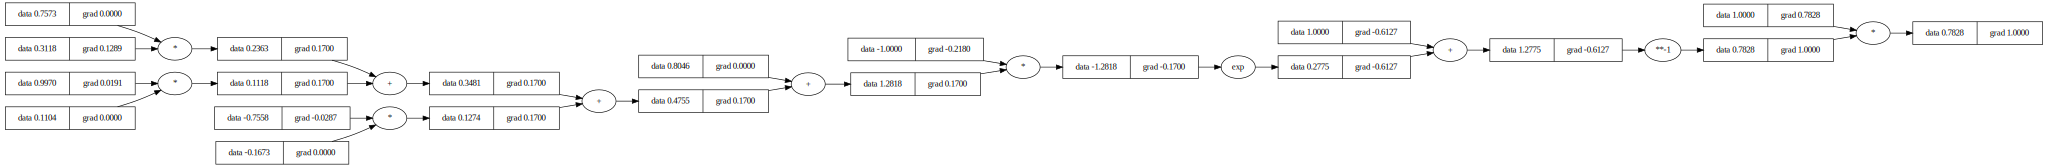

In [28]:
draw_dot(y[0])

In [38]:
a = get_value_array((2, 2, 2))
b = np.pad(a, ((0, 0), (1, 1), (1, 1)), constant_values=Value(0.0))
print(b)
print(b[0][1][1] == a[0][0][0])
print(b.shape)

[[[Value(data=0.0, grad=0) Value(data=0.0, grad=0)
   Value(data=0.0, grad=0) Value(data=0.0, grad=0)]
  [Value(data=0.0, grad=0) Value(data=-0.9282776717417387, grad=0)
   Value(data=0.1335615995918482, grad=0) Value(data=0.0, grad=0)]
  [Value(data=0.0, grad=0) Value(data=0.8185541063248887, grad=0)
   Value(data=0.35404821135262066, grad=0) Value(data=0.0, grad=0)]
  [Value(data=0.0, grad=0) Value(data=0.0, grad=0)
   Value(data=0.0, grad=0) Value(data=0.0, grad=0)]]

 [[Value(data=0.0, grad=0) Value(data=0.0, grad=0)
   Value(data=0.0, grad=0) Value(data=0.0, grad=0)]
  [Value(data=0.0, grad=0) Value(data=-0.08001379956675536, grad=0)
   Value(data=-0.15898650346467535, grad=0) Value(data=0.0, grad=0)]
  [Value(data=0.0, grad=0) Value(data=0.6587963216074313, grad=0)
   Value(data=0.8339381792332283, grad=0) Value(data=0.0, grad=0)]
  [Value(data=0.0, grad=0) Value(data=0.0, grad=0)
   Value(data=0.0, grad=0) Value(data=0.0, grad=0)]]]
True
(2, 4, 4)


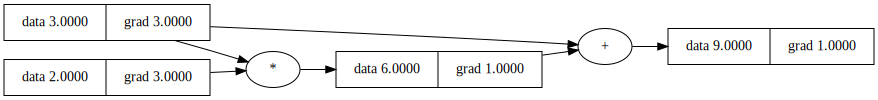

In [43]:
a = Value(2.0)
b = Value(3.0)
c = a * b + b
d = Value(1000.0)
d = c
d.backward()
draw_dot(d)

In [6]:
a = np.random.randn(64, 64)
b = np_array_to_value_array(a)
print(a)
print(b)
b.shape

[[ 0.23672952  0.27488486 -1.10522506 ... -2.3589958   0.06762012
  -0.77208947]
 [-1.24512379  0.07609675  0.91704399 ...  0.98064233 -0.24090048
   0.34982524]
 [-1.23710702  0.92696774 -0.53138055 ... -0.6785412  -1.31938998
   1.55840521]
 ...
 [-0.02443578 -1.48567647 -0.89121582 ...  1.94855434 -1.45687261
   0.26830893]
 [-0.40115557  1.37190142 -2.07183688 ...  2.01742032 -0.53774996
   0.9677382 ]
 [ 0.38459357 -0.47596176 -1.03484975 ...  1.29791429 -0.64102685
  -0.22773475]]
[[Value(data=0.23672951522678157, grad=0)
  Value(data=0.27488485701765697, grad=0)
  Value(data=-1.105225060058578, grad=0) ...
  Value(data=-2.3589958049918045, grad=0)
  Value(data=0.06762012033690692, grad=0)
  Value(data=-0.7720894736107528, grad=0)]
 [Value(data=-1.2451237944066964, grad=0)
  Value(data=0.07609674740345795, grad=0)
  Value(data=0.9170439930955026, grad=0) ...
  Value(data=0.9806423318638462, grad=0)
  Value(data=-0.2409004804381878, grad=0)
  Value(data=0.34982524336186893, grad=0

(64, 64)